# Imported Libraries

In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tf_keras
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score, f1_score
from aif360.metrics import ClassificationMetric
from aif360.datasets import BinaryLabelDataset
import matplotlib.pyplot as plt


# Helper Functions

In [57]:
def process_and_load_data(data = pd.DataFrame, target = str):
    #The input should only be a Pandas DataFrame 
 
    #This creates split datasets for training, testing, and validation
    #Additionally it prepares the input data sets for model fitting and predicting
   
    fixed_target = target.replace(' ', '_')
    data.rename(columns = {target: fixed_target}, inplace=True)
    


    X = data.drop(fixed_target, axis = 1)
    y = data[fixed_target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


    X_train[fixed_target] = y_train
    X_test[fixed_target] = y_test
    X_val[fixed_target] =  y_val
   
    X_train = tfdf.keras.pd_dataframe_to_tf_dataset(X_train, label=fixed_target)
    X_test = tfdf.keras.pd_dataframe_to_tf_dataset(X_test, label=fixed_target)
    X_val = tfdf.keras.pd_dataframe_to_tf_dataset(X_val, label=fixed_target)


    return X_train, X_test, X_val, y_train, y_test, y_val

In [85]:
def model_assessment(predictions, actuals):
    
   

    #Overall
    overall_accuracy = accuracy_score(actuals, predictions)
    overall_recall = recall_score(actuals, predictions)
    overall_precision = precision_score(actuals, predictions)



    results = pd.DataFrame({
        'Group': ['Overall'],
        'Accuracy': [overall_accuracy],
        'Recall': [overall_recall],
        'Precision': [overall_precision]
    })

    return results

In [78]:
def thresholds_assessment(raw_predictions, actuals, thresholds = list):
    accs =[]
    recalls = []
    precs = []
    for threshold in thresholds:
        new_preds = (raw_predictions >= threshold).astype(int)
        accs.append(accuracy_score(actuals, new_preds))
        recalls.append(recall_score(actuals, new_preds))
        precs.append(precision_score(actuals, new_preds))
    return {'Accuracy': accs, 'Recall': recalls, 'Precision': precs}

In [104]:
def fairness_metrics(input_df, predictions):

    binary_dataset = BinaryLabelDataset(df=input_df, 
                                    label_names=['Coronary heart disease'], 
                                    protected_attribute_names=['Gender'])

    # Create predictions dataset
    pred_df = input_df.drop('Coronary heart disease', axis = 1)
    pred_df['Coronary heart disease'] = predictions
    binary_predictions = BinaryLabelDataset(df=pred_df, 
                                            label_names=['Coronary heart disease'], 
                                            protected_attribute_names=['Gender'])

    # Compute metrics
    metric = ClassificationMetric(binary_dataset, binary_predictions, 
                                unprivileged_groups=[{'Gender': 0}], 
                                privileged_groups=[{'Gender': 1}]) 
    
    demographic_parity_difference = metric.statistical_parity_difference()
    equal_opportunity_difference = metric.equal_opportunity_difference()
    predictive_parity = metric.statistical_parity_difference()
    disparate_impact = metric.disparate_impact()


    #Output Metrics in a Pandas DataFrame
    fairness_table = pd.DataFrame({
        'Metric': ['Demographic Parity Difference', 'Equal Opportunity Difference',
                   'Predictive Parity', 'Disparate Impact'],
        'Value': [demographic_parity_difference, equal_opportunity_difference,
                  predictive_parity, disparate_impact]
    })

    return fairness_table

# Data Loading and Processing

In [107]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')
df.head()

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Diabetes,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),...,Basophils,Red blood cells,Hemoglobin,Red blood cell width,Platelet count,Mean volume of platelets,Coronary heart disease,Blood related diabetes,Moderate-work,Vigorous-work
4,92.5,29.10,122.0,82.0,Male,597.0,No,5.5,7.21,1.08,...,5.397605e-79,5.13,14.5,13.1,209.0,10.4,No,No,17.0,Yes
6,78.0,29.39,130.0,78.0,Female,712.0,No,5.8,6.34,2.73,...,5.397605e-79,4.60,13.4,14.3,244.0,8.2,No,Yes,3.0,No
9,111.8,30.94,152.0,98.0,Male,518.0,No,5.5,3.62,1.31,...,5.397605e-79,5.00,15.4,13.7,167.0,9.4,No,Don't know,13.0,Don't know
13,75.5,27.33,142.0,56.0,Male,973.0,No,5.8,4.50,1.04,...,5.397605e-79,5.32,16.6,12.4,160.0,9.0,No,No,9.0,Yes
14,81.6,26.68,106.0,68.0,Female,459.0,No,4.6,5.15,1.49,...,5.397605e-79,4.14,13.3,11.9,255.0,7.7,No,No,13.0,Yes


In [108]:
# Male = 1
# Female = 0
# CHD Positive = 1
# CHD Negative = 1
df['Gender'] = df['Gender'].mask(df['Gender'] == 'Male', 1).mask(df['Gender'] == 'Female', 0)
df['Coronary heart disease'] = df['Coronary heart disease'].mask(df['Coronary heart disease'] == 'Yes', 1).mask(df['Coronary heart disease'] == 'No', 0)
categorical_cols = ['Diabetes', 'Blood related diabetes', 'Vigorous-work']

# One-hot encoding
#df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

#Correct Data Type
df['Coronary heart disease'] = df['Coronary heart disease'].astype(int)

In [60]:
X_train, X_test, X_val, y_train, y_test, y_val  = process_and_load_data(df, 'Coronary heart disease')

/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py:1162: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe[col] = dataframe[col].fillna("")


/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py:1162: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe[col] = dataframe[col].fillna("")
/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/tensorflow_decision_forests/keras/core_inference.py:1162: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataframe[col] = dataframe[col].fillna("")


# Base Line Decision Tree Model

In [64]:
rf = tfdf.keras.RandomForestModel(verbose=2)

Use 16 thread(s) for training
Use /tmp/tmpayuy1cjs as temporary training directory


In [65]:
rf.fit(X_train)

Reading training dataset...
Training tensor examples:
Features: {'Weight': <tf.Tensor 'data:0' shape=(None,) dtype=float64>, 'Body_mass_index': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'Systolic': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'Diastolic': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'Gender': <tf.Tensor 'data_4:0' shape=(None,) dtype=int64>, 'Age': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'Diabetes': <tf.Tensor 'data_6:0' shape=(None,) dtype=string>, 'Glycohemoglobin': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'Cholesterol': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'High-density_lipoprotein_(HDL)': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'Albumin': <tf.Tensor 'data_10:0' shape=(None,) dtype=float64>, 'Alanine_aminotransferase_(ALT)': <tf.Tensor 'data_11:0' shape=(None,) dtype=float64>, 'Aspartate_aminotransferase_(AST)': <tf.Tensor 'data_12:0' shape=(None,) dtype=float64>, 'Alkaline_phosphatase_(ALP)':

# Evaluation

In [88]:
rf.compile(metrics=["accuracy"])
evaluation = rf.evaluate(X_test, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

10/10 [==============================] - 0s 28ms/step - loss: 0.0000e+00 - accuracy: 0.9595

loss: 0.0000
accuracy: 0.9595


In [67]:
rf.summary()

Model: "random_forest_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (34):
	Age
	Alanine_aminotransferase_(ALT)
	Albumin
	Alkaline_phosphatase_(ALP)
	Aspartate_aminotransferase_(AST)
	Basophils
	Bilirubin
	Blood_related_diabetes
	Body_mass_index
	Cholesterol
	Creatinine
	Diabetes
	Diastolic
	Gamma-glutamyl_transferase_(GGT)
	Gender
	Glucose
	Glycohemoglobin
	Hemoglobin
	High-density_lipoprotein_(HDL)
	Iron
	Lactate_dehydrogenase_(LDH)
	Mean_volume_of_platelets
	Moderate-work
	Phosphorus
	Platelet_count
	Protein
	Red_blood_cell_width
	Red_blood_cells
	Systolic
	Triglycerides
	Uric_acid
	Vigorous-work
	Weight
	White_blood_cells

No weights

Variable Importance: 

In [68]:
rf.make_inspector().evaluation()

Evaluation(num_examples=27492, accuracy=0.9583878946602647, loss=0.29156053293904644, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

Text(0, 0.5, 'Logloss (out-of-bag)')

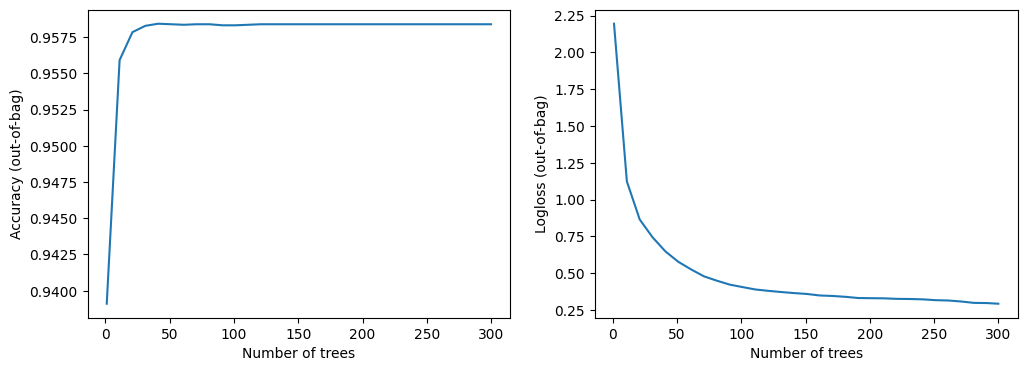

In [69]:
logs = rf.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")


# Threshold Assessment

In [90]:
raw_preds = rf.predict(X_val).flatten()

10/10 [==============================] - 0s 29ms/step


In [91]:
thresholds = np.arange(0.01, 1, 0.05)
metrics = thresholds_assessment(raw_preds, y_test, thresholds)

/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dsilva/DSC-180-Capstone/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

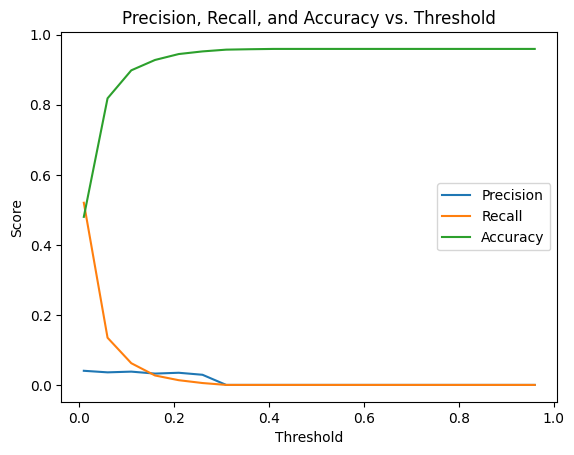

In [92]:
plt.plot(thresholds, metrics['Precision'], label='Precision')
plt.plot(thresholds, metrics['Recall'], label='Recall')
plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()

In [95]:
f1_scores = []
for t in thresholds:
    preds = (raw_preds  >= t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)

optimal_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal threshold for F1-Score: {optimal_threshold}")

Optimal threshold for F1-Score: 0.11


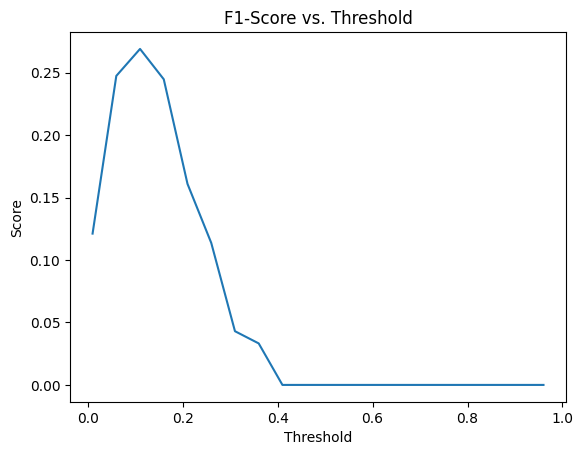

In [96]:
plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1-Score vs. Threshold')
plt.show()

In [97]:
preds = (raw_preds >= 0.11).astype(int)

In [98]:
model_assessment(preds, y_val)

,Group,Accuracy,Recall,Precision
0,Overall,0.923505,0.365439,0.212871


# Fairness Assessment

In [110]:
test_df = pd.get_dummies(df.copy(), columns=categorical_cols, drop_first=True)
X_train, X_test= train_test_split(test_df , test_size=0.2, random_state=42)
X_train, X_val = train_test_split(X_train, test_size=0.25, random_state=42)
fairness_metrics(X_val, preds)

,Metric,Value
0,Demographic Parity Difference,-0.077414
1,Equal Opportunity Difference,-0.311342
2,Predictive Parity,-0.077414
3,Disparate Impact,0.269746
